<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB_miniproject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < 영화 관객수 예측 경진대회>

- title : 영화의 제목

- distributor : 배급사

- genre : 장르

- release_time : 개봉일

- time : 상영시간(분)

- screening_rat : 상영등급

- director : 감독이름

- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단, 관객수가 알려지지 않은 영화 제외)

- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단, 관객수가 알려지지 않은 영화 제외)

- num_staff : 스텝수

- num_actor : 주연배우수

- box_off_num : 관객수


# 1. 라이브러리 및 데이터

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

In [ ]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [ ]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [ ]:
submission.head(3)

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0


# 2. 탐색적 자료분석(EDA)



---



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


### (1) 'title' 칼럼 삭제





In [ ]:
# 영화 제목의 길이와 관객수 사이에 상관관계가 있을까?

result = []
for i in range(0, 600):
    word_length = len(train['title'][i])
    result.append(word_length)

train_title = train.copy()
train_title['title_length'] = result

title_box_corr = train_title[['title_length','box_off_num']].corr(method='pearson')
title_box_corr

,title_length,box_off_num
title_length,1.000000,-0.085964
box_off_num,-0.085964,1.000000


In [ ]:
# 상관계수는 -0.09로 매우 낮음
# 의미 없는 데이터 제거

train = train.drop('title', axis=1)
test = test.drop('title', axis=1)

### (2) 'distributor' 칼럼 전처리

In [ ]:
# (주) 문자열 제거

train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [ ]:
# 숫자·영문·한글 외 모든 특수문자 제거

train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [ ]:
# 배급사 이름 통합

def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [ ]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [ ]:
# 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

tr_dist_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_dist_rank

,distributor,num_rank
109,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
51,사람과사람들,42.0
96,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
111,전망좋은영화사,1214237.0
104,이십세기폭스코리아,1422844.0
55,쇼박스,2138560.0
83,영구아트무비,2541603.0


In [ ]:
tr_dist_rank['num_rank'] = [i + 1 for i in range(tr_dist_rank.shape[0])]
tr_dist_rank

,distributor,num_rank
109,인피니티엔터테인먼트,1
15,고구마공작소,2
51,사람과사람들,3
96,위드시네마,4
19,나우콘텐츠,5
...,...,...
111,전망좋은영화사,143
104,이십세기폭스코리아,144
55,쇼박스,145
83,영구아트무비,146


In [ ]:
# 최종 데이터 병합

train = pd.merge(train, tr_dist_rank, how = 'left')
test = pd.merge(test, tr_dist_rank, how = 'left')
test.fillna(0, inplace = True)

In [ ]:
train.drop('distributor', axis=1, inplace=True)
test.drop('distributor', axis=1, inplace=True)

### (3) 'genre' 칼럼 전처리

In [ ]:
train['genre'].unique()

array(['액션', '느와르', '코미디', '다큐멘터리', '뮤지컬', '드라마', '멜로/로맨스', '공포', '서스펜스',
       '애니메이션', '미스터리', 'SF'], dtype=object)

In [ ]:
train.groupby('genre').box_off_num.mean().sort_values()

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


In [ ]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

In [ ]:
train.drop('genre', axis=1, inplace=True)
test.drop('genre', axis=1, inplace=True)

### (4) 'release_time' 칼럼 전처리

In [ ]:
# year 컬럼 추가

train['year'] = pd.to_datetime(train['release_time']).dt.year
test['year'] = pd.to_datetime(test['release_time']).dt.year

In [ ]:
# month 컬럼 추가

train['month'] = pd.to_datetime(train['release_time']).dt.month
test['month'] = pd.to_datetime(test['release_time']).dt.month

In [ ]:
# drop

train = train.drop('release_time', axis=1)
test = test.drop('release_time', axis=1)

### (5) 'time' 칼럼 전처리


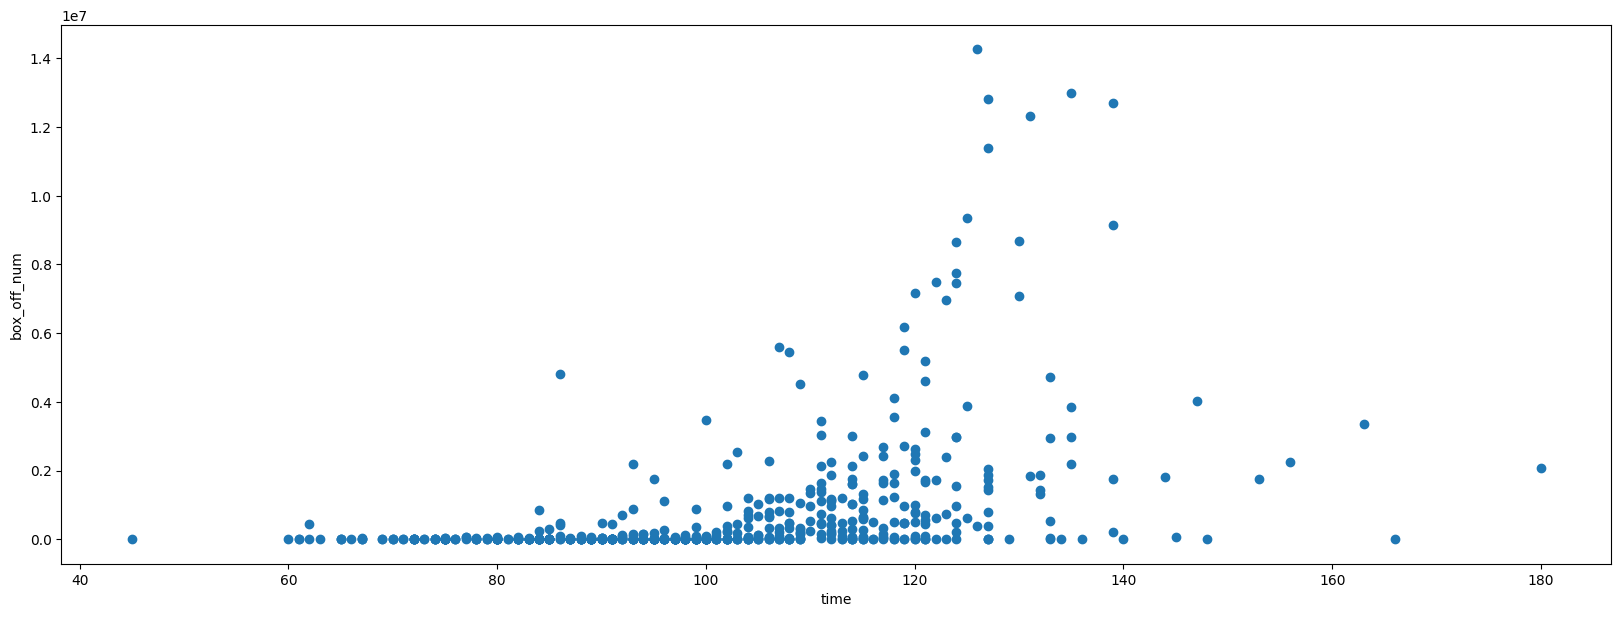

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plt.scatter(train['time'], train['box_off_num'])
plt.xlabel('time')
plt.ylabel('box_off_num')
plt.show()

### (6) 'screening_rat' 칼럼 전처리

In [ ]:
pd.pivot_table(train[['screening_rat','box_off_num']], index=['screening_rat'], aggfunc=['count','sum'])

,count,sum
,box_off_num,box_off_num
screening_rat,,
12세 관람가,102,86188052
15세 관람가,202,251998766
전체 관람가,92,12429242
청소년 관람불가,204,74292991


In [ ]:
train = pd.get_dummies(columns = ['screening_rat'], data = train)
test = pd.get_dummies(columns = ['screening_rat'], data = test)

### (7) 'director' 칼럼 삭제

In [ ]:
# 고유한 감독 수 확인

train['director'].nunique()

472

In [ ]:
# 감독명이 너무 다양하므로 제거

train = train.drop('director', axis=1)
test = test.drop('director', axis=1)

### (8) 'dir_prev_bfnum' 칼럼 삭제

In [ ]:
# 결측률이 50% 이상이므로 칼럼 제거

train = train.drop(['dir_prev_bfnum'], axis = 1)
test =  test.drop(['dir_prev_bfnum'], axis = 1)

### (9) 'dir_prev_num' 칼럼 전처리

In [ ]:
train['dir_prev_num'].value_counts()

,count
dir_prev_num,
0,330
1,113
2,86
3,47
4,20
5,4


In [ ]:
train[['dir_prev_num','box_off_num']].corr(method='spearman')

,dir_prev_num,box_off_num
dir_prev_num,1.000000,0.394862
box_off_num,0.394862,1.000000


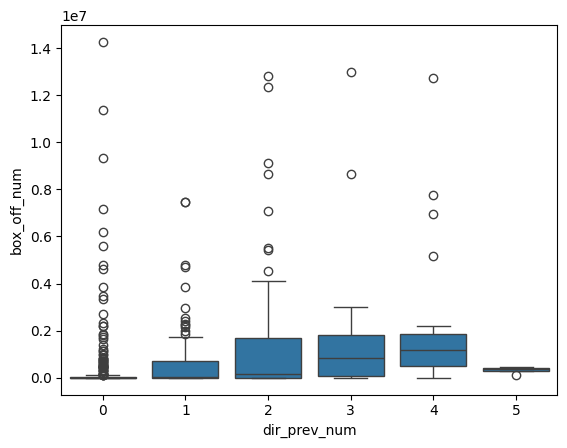

In [ ]:
sns.boxplot(x='dir_prev_num', y='box_off_num', data=train)
plt.show()


### (10) 'num_staff' 칼럼 전처리

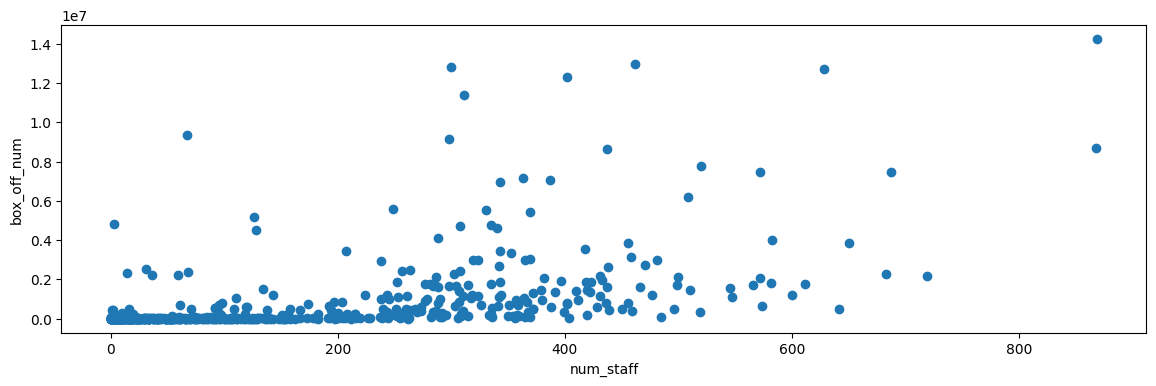

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.scatter(train['num_staff'], train['box_off_num'])
plt.xlabel('num_staff')
plt.ylabel('box_off_num')
plt.show()

### (11) 'num_actor' 칼럼 전처리

In [ ]:
train['num_actor'].value_counts()

,count
num_actor,
2,154
3,143
4,114
5,58
1,35
6,33
7,16
8,16
0,9


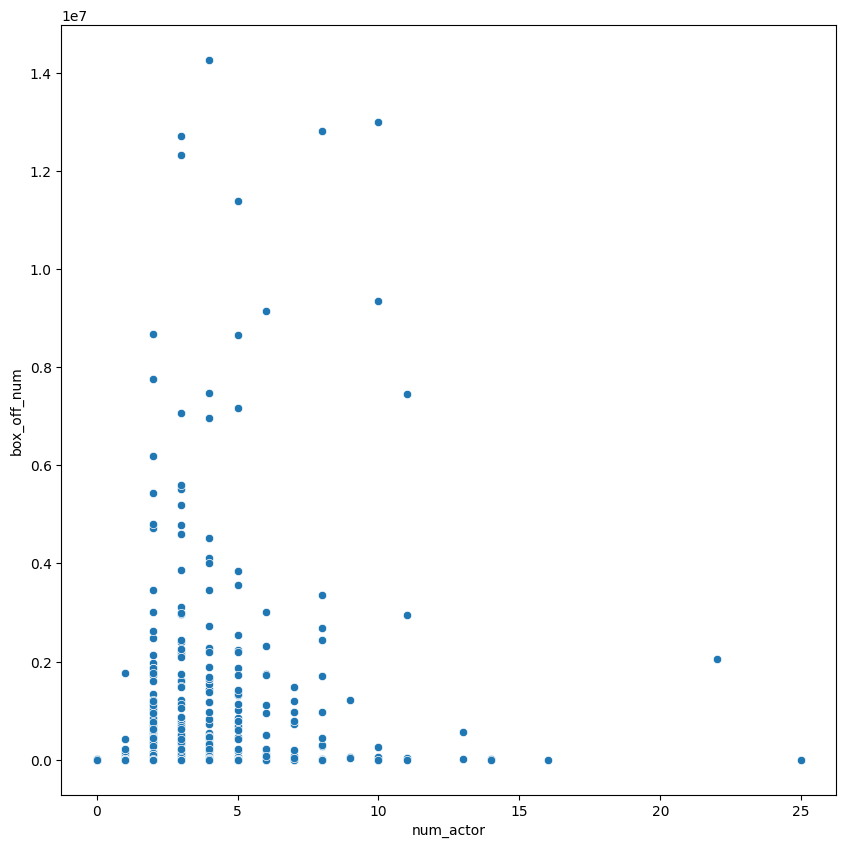

In [ ]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_actor', y = 'box_off_num')
plt.xlabel('num_actor')
plt.ylabel('box_off_num')
plt.show()

### (12) 로그 변환

In [ ]:
cols = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'num_rank', 'genre_rank', 'year', 'month']

corr_matrix = train[cols].corr()
corr_matrix

,time,dir_prev_num,num_staff,num_actor,box_off_num,num_rank,genre_rank,year,month
time,1.000000,0.306727,0.623205,0.114153,0.441452,0.525554,0.404035,-0.062575,-0.023969
dir_prev_num,0.306727,1.000000,0.450706,0.014006,0.259674,0.361585,0.236391,0.132621,0.034019
num_staff,0.623205,0.450706,1.000000,0.077871,0.544265,0.653489,0.466936,-0.032891,-0.002841
num_actor,0.114153,0.014006,0.077871,1.000000,0.111179,0.080893,0.058944,-0.098869,-0.015063
box_off_num,0.441452,0.259674,0.544265,0.111179,1.000000,0.407956,0.279454,-0.002497,0.019104
num_rank,0.525554,0.361585,0.653489,0.080893,0.407956,1.000000,0.292513,-0.069556,-0.061528
genre_rank,0.404035,0.236391,0.466936,0.058944,0.279454,0.292513,1.000000,-0.039920,-0.022913
year,-0.062575,0.132621,-0.032891,-0.098869,-0.002497,-0.069556,-0.039920,1.000000,0.046627
month,-0.023969,0.034019,-0.002841,-0.015063,0.019104,-0.061528,-0.022913,0.046627,1.000000


<Axes: >

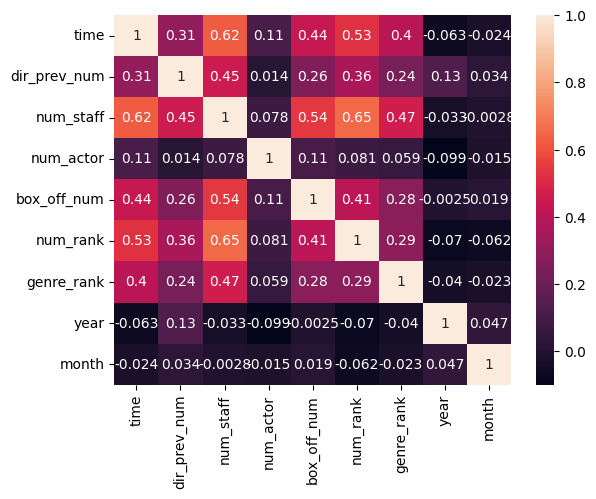

In [ ]:
sns.heatmap(corr_matrix, annot = True)

time            skewness = 0.35


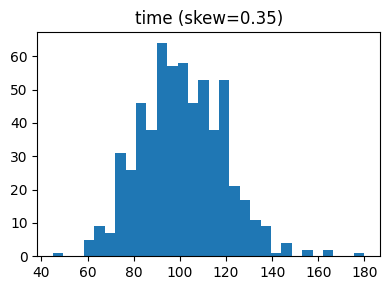

dir_prev_num    skewness = 1.25


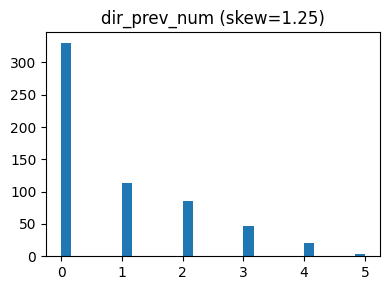

num_staff       skewness = 1.23


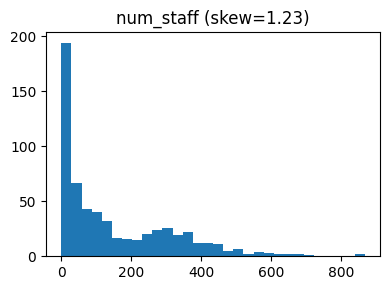

num_actor       skewness = 2.95


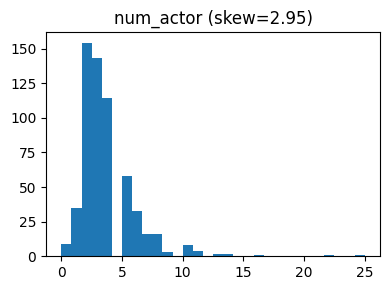

box_off_num     skewness = 4.33


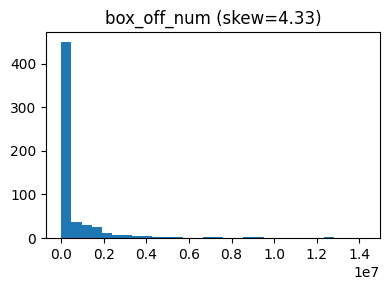

num_rank        skewness = -0.30


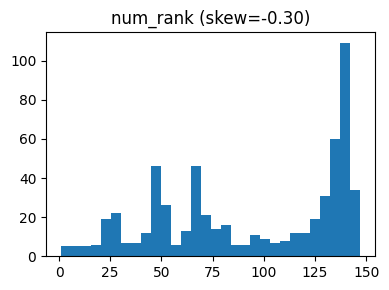

genre_rank      skewness = -0.37


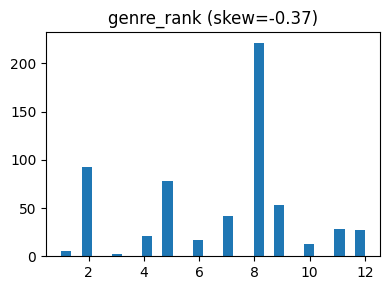

year            skewness = -0.23


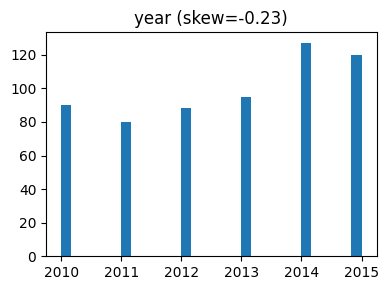

month           skewness = -0.20


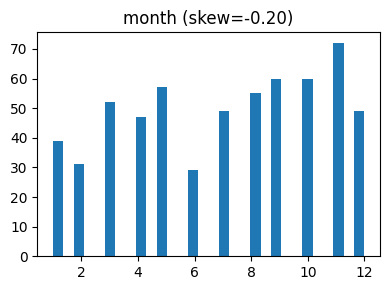

In [ ]:
num_cols = train.select_dtypes(include=[np.number]).columns

# 히스토그램 + skewness 계산
skew_threshold = 1
to_log = []            # 로그 변환할 컬럼 모음

for col in num_cols:
    skewness = train[col].skew()
    print(f"{col:15s} skewness = {skewness:.2f}")

    # 히스토그램
    plt.figure(figsize=(4,3))
    plt.hist(train[col].dropna(), bins=30)
    plt.title(f"{col} (skew={skewness:.2f})")
    plt.tight_layout()
    plt.show()

    # 절단 기준 넘으면 로그 변환 리스트에 추가
    if abs(skewness) > skew_threshold:
        to_log.append(col)

In [ ]:
print("\n로그 변환 추천 피처:", to_log)


로그 변환 추천 피처: ['dir_prev_num', 'num_staff', 'num_actor', 'box_off_num']


In [ ]:
# 로그 변환 적용

for col in to_log:
    train[f"{col}_log"] = np.log1p(train[col])
    # 변환 후 skewness 다시 확인
    new_skew = train[f"{col}_log"].skew()
    print(f"{col:15s} → {col+'_log':15s} new skew = {new_skew:.2f}")

dir_prev_num    → dir_prev_num_log new skew = 0.66
num_staff       → num_staff_log   new skew = -0.71
num_actor       → num_actor_log   new skew = 0.06
box_off_num     → box_off_num_log new skew = 0.13


In [ ]:
# 원본 컬럼 삭제
train.drop(columns=to_log, inplace=True)

In [ ]:
test_to_log = ['dir_prev_num', 'num_staff', 'num_actor']

In [ ]:
# Test에 로그 변환 적용
for col in test_to_log:
    test[f"{col}_log"] = np.log1p(test[col])

# Test에서 원본 컬럼 삭제
test.drop(columns=test_to_log, inplace=True)

test.head()


,time,num_rank,genre_rank,year,month,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,dir_prev_num_log,num_staff_log,num_actor_log
0,125,132.0,12,2010,1,False,False,False,True,1.098612,5.720312,1.386294
1,113,145.0,5,2010,1,True,False,False,False,1.609438,5.620401,1.386294
2,115,141.0,8,2010,1,True,False,False,False,1.386294,6.040255,2.079442
3,116,145.0,11,2010,2,False,True,False,False,1.098612,6.013715,1.098612
4,110,141.0,7,2010,2,False,True,False,False,0.693147,5.942799,0.693147


In [ ]:
train.head(3)

,time,num_rank,genre_rank,year,month,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,dir_prev_num_log,num_staff_log,num_actor_log,box_off_num_log
0,96,134,11,2012,11,False,False,False,True,0.000000,4.521789,1.098612,10.060449
1,130,145,12,2015,11,False,False,False,True,1.098612,5.961005,1.386294,15.771725
2,123,145,11,2013,6,False,True,False,False,1.609438,5.840642,1.609438,15.755558


In [ ]:
# 최종 데이터
train_final = train.copy()
test_final = test.copy()

# 3. 모델링

## Train/Validation 분할

In [ ]:
from sklearn.model_selection import train_test_split

# 특성(X)과 타깃(y) 분리
X = train_final.drop(columns=['box_off_num_log'])
y = train_final['box_off_num_log']

# 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,        # 검증 세트 비율
    random_state=42,      # 시드 고정
    shuffle=True          # 섞은 뒤 분할
)

# 3) 결과 확인
print("훈련 세트 크기:", X_train.shape, y_train.shape)
print("검증 세트 크기:", X_val.shape,   y_val.shape)


훈련 세트 크기: (450, 12) (450,)
검증 세트 크기: (150, 12) (150,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 593 to 102
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    450 non-null    int64  
 1   num_rank                450 non-null    int64  
 2   genre_rank              450 non-null    int64  
 3   year                    450 non-null    int32  
 4   month                   450 non-null    int32  
 5   screening_rat_12세 관람가   450 non-null    bool   
 6   screening_rat_15세 관람가   450 non-null    bool   
 7   screening_rat_전체 관람가    450 non-null    bool   
 8   screening_rat_청소년 관람불가  450 non-null    bool   
 9   dir_prev_num_log        450 non-null    float64
 10  num_staff_log           450 non-null    float64
 11  num_actor_log           450 non-null    float64
dtypes: bool(4), float64(3), int32(2), int64(3)
memory usage: 29.9 KB


In [ ]:
from sklearn.preprocessing import StandardScaler

num_feats = ['time', 'num_rank', 'genre_rank', 'year', 'month', 'dir_prev_num_log', 'num_staff_log', 'num_actor_log']
scaler    = StandardScaler()

scaler.fit(X_train[num_feats])                       # 오직 X_train만으로 fit
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()

X_train_scaled[num_feats] = scaler.transform(X_train[num_feats])
X_val_scaled[num_feats]   = scaler.transform(X_val[num_feats])

# 최종 테스트 세트도 동일하게
X_test_scaled = test_final.copy()
X_test_scaled[num_feats] = scaler.transform(test_final[num_feats])

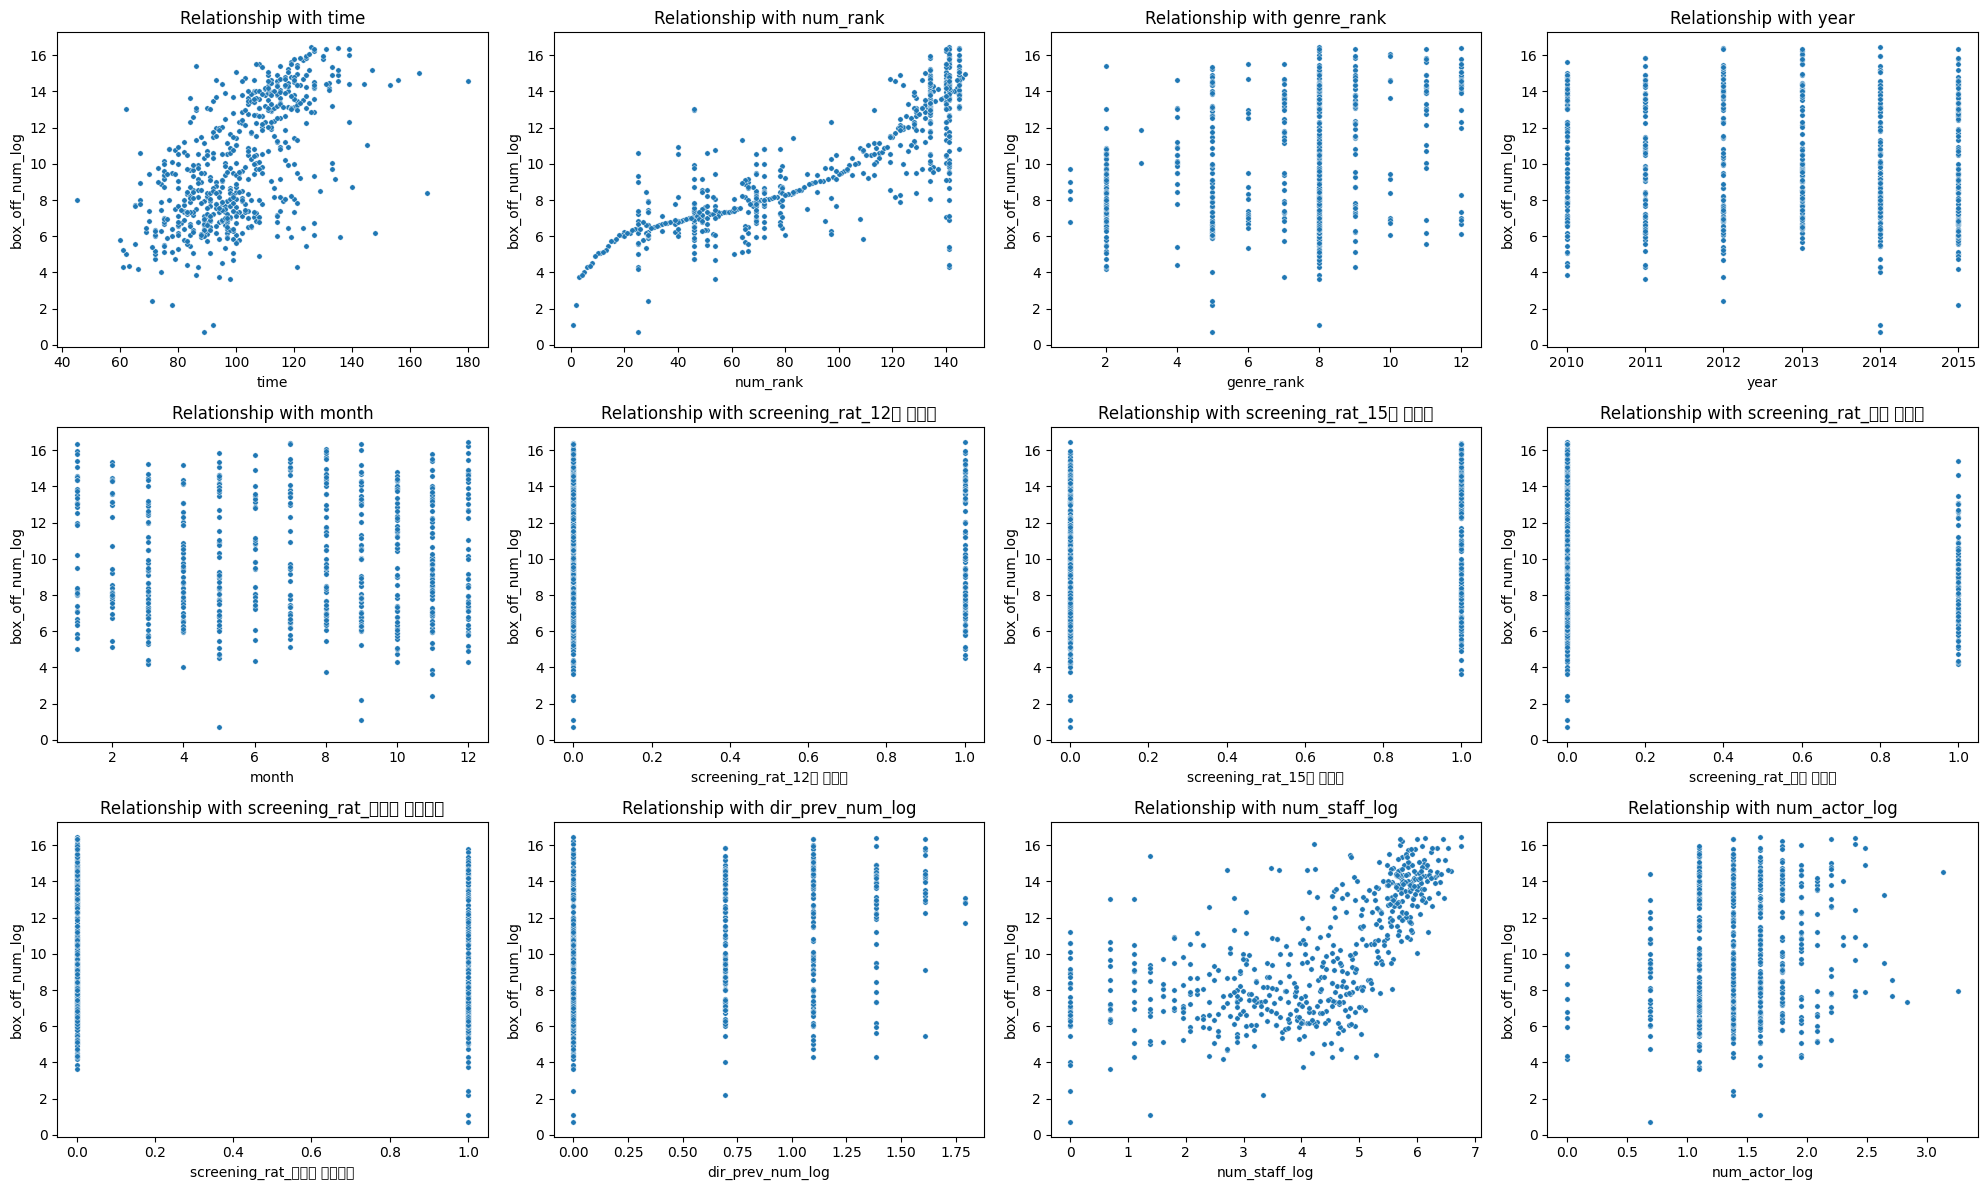

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 피처 목록, 컬럼 목록 가져오기
features = list(X.columns)
num_features = len(features)

# subplot 행, 열 개수
cols = 4
rows = (num_features + cols - 1) // cols  # 올림 계산

# 전체 크기 설정
plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(x=X[feature], y=y, s=15)  # y: train_final['box_off_num_log']
    plt.title(f'Relationship with {feature}')
    plt.xlabel(feature)
    plt.ylabel('box_off_num_log')

plt.tight_layout()
plt.show()

##  (1) Lasso Regression

In [ ]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
# 알파(정규화 강도) 후보 생성
alphas = np.logspace(-4, 0, 50)

# LassoCV로 알파 튜닝 (5-폴드 CV, max_iter 높여 수렴 보장)
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_
print(f"최적 alpha: {best_alpha:.5f}")

# 최적 alpha로 최종 모델 학습
lasso = Lasso(
    alpha=best_alpha,
    random_state=42,
    max_iter=10000
)
lasso.fit(X_train_scaled, y_train)

# 검증셋 예측 및 역변환
y_val_pred_log = lasso.predict(X_val_scaled)
y_val_pred     = np.expm1(y_val_pred_log)

# RMSE 평가 (원래 스케일)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (original scale): {rmse:.4f}")

# 중요 변수 확인 (coef가 0이 아닌 것들)
coef = pd.Series(lasso.coef_, index=X_train.columns)
print("=== 사용된 특성 계수 ===")
print(coef[coef!=0].sort_values())

# 테스트셋 예측
y_test_pred = np.expm1(lasso.predict(X_test_scaled))

최적 alpha: 0.05964
Validation RMSE (original scale): 345696.2427
=== 사용된 특성 계수 ===
screening_rat_청소년 관람불가   -0.295027
num_actor_log             0.043020
month                     0.091825
dir_prev_num_log          0.207954
num_staff_log             0.387851
time                      0.513511
num_rank                  2.068716
dtype: float64


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 모든 피처를 대상으로 다항 피처 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly   = poly.transform(X_val_scaled)
X_test_poly  = poly.transform(X_test_scaled)

# 알파 후보 생성
alphas = np.logspace(-4, 0, 50)

# LassoCV로 알파 튜닝
lasso_cv_poly = LassoCV(
    alphas=alphas,
    cv=5,
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)
lasso_cv_poly.fit(X_train_poly, y_train)
best_alpha_poly = lasso_cv_poly.alpha_
print(f"\n[Poly 적용] 최적 alpha: {best_alpha_poly:.5f}")

# 최종 Lasso 학습
lasso_poly = Lasso(
    alpha=best_alpha_poly,
    random_state=42,
    max_iter=10000
)
lasso_poly.fit(X_train_poly, y_train)

# 검증셋 예측 및 평가 (원래 스케일로 복원 후 RMSE 계산)
y_val_actual = np.expm1(y_val)
y_val_pred_log_poly = lasso_poly.predict(X_val_poly)
y_val_pred_poly     = np.expm1(y_val_pred_log_poly)
rmse_poly = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_poly))
print(f"[Poly 적용] Validation RMSE (original scale): {rmse_poly:.4f}")

# 중요 변수 출력
feature_names_poly = poly.get_feature_names_out(input_features=X_train.columns)
coef_poly = pd.Series(lasso_poly.coef_, index=feature_names_poly)
print("=== [Poly 적용] 사용된 특성 계수 ===")
print(coef_poly[coef_poly != 0].sort_values())

# 테스트셋 예측
y_test_pred_poly = np.expm1(lasso_poly.predict(X_test_poly))


[Poly 적용] 최적 alpha: 0.07197
[Poly 적용] Validation RMSE (original scale): 1021382.5566
=== [Poly 적용] 사용된 특성 계수 ===
time^2                                -0.112106
screening_rat_청소년 관람불가^2              -0.026496
screening_rat_청소년 관람불가                -0.022556
year^2                                -0.000243
num_rank dir_prev_num_log              0.016730
genre_rank num_actor_log               0.018595
month                                  0.022672
month screening_rat_청소년 관람불가           0.026982
time genre_rank                        0.048292
time screening_rat_15세 관람가             0.056379
num_rank month                         0.059580
dir_prev_num_log                       0.077416
num_actor_log                          0.108513
num_rank num_staff_log                 0.123621
time num_staff_log                     0.151346
time dir_prev_num_log                  0.154643
screening_rat_15세 관람가 num_staff_log    0.184733
genre_rank num_staff_log               0.251749
num_staff_log^2       

## (2) Linear, Ridge, Elasticnet

**Ridge**

alpha: 규제 강도
- 규제 약화 → 모델이 더 자유롭게 학습 → 훈련/검증 데이터에 더 잘 맞춤, 너무 작으면 과적합 위험
- 규제 강화 → 모델 단순화 + 과적합 방지 + 안정성 강화, 너무 크면 과소적합으로 성능 저하 가능성

**Elasticnet**

- alpha: 규제 강도의 전체 스케일 (L1과 L2 합산 규제 크기)


- l1_ratio: 규제의 L1(Lasso)와 L2(Ridge) 비율.

- l1_ratio=0 → Pure Ridge

- l1_ratio=1 → Pure Lasso

- 중간 값 → L1과 L2 혼합(ElasticNet 본질)



In [ ]:
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 결과 저장 리스트
results = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = np.expm1(lr.predict(X_val_scaled))
y_val_actual = np.expm1(y_val)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
r2 = r2_score(y_val_actual, y_pred)
results.append(['Linear', 'default', rmse, r2])

# poly 적용 전
# Ridge 튜닝
alpha_list_ridge = [0.01, 0.1, 1, 10, 20]
for alpha in alpha_list_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred = np.expm1(ridge.predict(X_val_scaled))
    y_val_actual = np.expm1(y_val)
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
    r2 = r2_score(y_val_actual, y_pred)
    results.append(['Ridge', f'alpha={alpha}', rmse, r2])

# ElasticNet 튜닝
alpha_list_en = [0.01, 0.1, 1]
l1_ratio_list = [0.2, 0.5, 0.8]
for alpha in alpha_list_en:
    for l1_ratio in l1_ratio_list:
        en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        en.fit(X_train_scaled, y_train)
        y_pred = np.expm1(en.predict(X_val_scaled))
        y_val_actual = np.expm1(y_val)
        rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
        r2 = r2_score(y_val_actual, y_pred)
        results.append(['ElasticNet', f'alpha={alpha}, l1_ratio={l1_ratio}', rmse, r2])

# 결과 출력
results_df = pd.DataFrame(results, columns=['Model', 'Params', 'RMSE', 'R2'])
print("\n=== Linear, Ridge, ElasticNet (Poly 없이) 성능 비교 ===")
print(results_df)

# 베스트 모델(RMSE 최소) 찾기
best_model_row = results_df[results_df['RMSE'] == results_df['RMSE'].min()].iloc[0]
print("\n=== Best Model (Lowest RMSE) ===")
print(f"Model: {best_model_row['Model']}")
print(f"Params: {best_model_row['Params']}")
print(f"RMSE: {best_model_row['RMSE']:.4f}")
print(f"R2: {best_model_row['R2']:.4f}")


=== Linear, Ridge, ElasticNet (Poly 없이) 성능 비교 ===
         Model                    Params          RMSE        R2
0       Linear                   default  1.059699e+06  0.241879
1        Ridge                alpha=0.01  1.059707e+06  0.241868
2        Ridge                 alpha=0.1  1.059779e+06  0.241766
3        Ridge                   alpha=1  1.060495e+06  0.240741
4        Ridge                  alpha=10  1.067606e+06  0.230525
5        Ridge                  alpha=20  1.075331e+06  0.219348
6   ElasticNet  alpha=0.01, l1_ratio=0.2  1.063071e+06  0.237048
7   ElasticNet  alpha=0.01, l1_ratio=0.5  1.063085e+06  0.237027
8   ElasticNet  alpha=0.01, l1_ratio=0.8  1.063615e+06  0.236266
9   ElasticNet   alpha=0.1, l1_ratio=0.2  1.098928e+06  0.184712
10  ElasticNet   alpha=0.1, l1_ratio=0.5  1.104460e+06  0.176483
11  ElasticNet   alpha=0.1, l1_ratio=0.8  1.111383e+06  0.166126
12  ElasticNet     alpha=1, l1_ratio=0.2  1.254614e+06 -0.062656
13  ElasticNet     alpha=1, l1_ratio=0.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 다항 피처 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
y_val_actual = np.expm1(y_val)

results = []

# LinearRegression (기본)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred = np.expm1(lr_poly.predict(X_val_poly))
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
r2 = r2_score(y_val_actual, y_pred)
results.append(['Linear', 'default', rmse, r2])

# Ridge 튜닝
alpha_list_ridge = [0.01, 0.1, 1]
for alpha in alpha_list_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_poly, y_train)
    y_pred = np.expm1(ridge.predict(X_val_poly))
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
    r2 = r2_score(y_val_actual, y_pred)
    results.append(['Ridge', f'alpha={alpha}', rmse, r2])

# ElasticNet 튜닝
alpha_list_en = [0.01, 0.1, 1]
l1_ratio_list = [0.2, 0.5, 0.8]
for alpha in alpha_list_en:
    for l1_ratio in l1_ratio_list:
        en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        en.fit(X_train_poly, y_train)
        y_pred = np.expm1(en.predict(X_val_poly))
        rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
        r2 = r2_score(y_val_actual, y_pred)
        results.append(['ElasticNet', f'alpha={alpha}, l1_ratio={l1_ratio}', rmse, r2])

# 결과 출력
results_df = pd.DataFrame(results, columns=['Model', 'Params', 'RMSE', 'R2'])
print("\n=== (Poly) Linear, Ridge, ElasticNet 비교 ===")
print(results_df)

# 베스트 모델(RMSE 최소) 찾기
best_model_row = results_df[results_df['RMSE'] == results_df['RMSE'].min()].iloc[0]
print("\n=== Best Model (Lowest RMSE) ===")
print(f"Model: {best_model_row['Model']}")
print(f"Params: {best_model_row['Params']}")
print(f"RMSE: {best_model_row['RMSE']:.4f}")
print(f"R2: {best_model_row['R2']:.4f}")


=== (Poly) Linear, Ridge, ElasticNet 비교 ===
         Model                    Params          RMSE        R2
0       Linear                   default  9.208684e+05  0.427510
1        Ridge                alpha=0.01  9.208706e+05  0.427507
2        Ridge                 alpha=0.1  9.208915e+05  0.427481
3        Ridge                   alpha=1  9.211308e+05  0.427184
4   ElasticNet  alpha=0.01, l1_ratio=0.2  9.203471e+05  0.428158
5   ElasticNet  alpha=0.01, l1_ratio=0.5  9.193072e+05  0.429449
6   ElasticNet  alpha=0.01, l1_ratio=0.8  9.195326e+05  0.429170
7   ElasticNet   alpha=0.1, l1_ratio=0.2  9.711588e+05  0.363273
8   ElasticNet   alpha=0.1, l1_ratio=0.5  1.007315e+06  0.314980
9   ElasticNet   alpha=0.1, l1_ratio=0.8  1.034813e+06  0.277069
10  ElasticNet     alpha=1, l1_ratio=0.2  1.215289e+06  0.002915
11  ElasticNet     alpha=1, l1_ratio=0.5  1.269598e+06 -0.088192
12  ElasticNet     alpha=1, l1_ratio=0.8  1.281547e+06 -0.108772

=== Best Model (Lowest RMSE) ===
Model: Elas

In [ ]:
# best model로 test 예측
best_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
best_model.fit(X_train_poly, y_train)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = poly.fit_transform(X_test_scaled)

# 테스트셋 예측
y_test_pred_poly = np.expm1(best_model.predict(X_test_poly))
y_test_pred_poly

array([ 3.84067674e+05,  5.16547501e+05,  1.00832325e+06,  1.13118268e+06,
        3.70137873e+05,  1.15485233e+03,  1.20821363e+03,  6.94593519e+02,
        2.14688211e+03,  2.11745657e+03,  1.63897775e+05,  2.62246181e+05,
        6.93894470e+02,  4.75635471e+03,  3.16597302e+05,  1.88222088e+06,
        5.70467827e+03,  7.26921320e+05,  1.59161938e+05,  6.51320290e+04,
        1.02365176e+02,  1.42885048e+03,  4.87681359e+03,  3.47714900e+01,
        9.48583859e+01,  9.11218929e+05,  4.33629287e+02,  5.22998535e+05,
        6.59436201e+03,  3.63033606e+02,  1.26868480e+05,  1.49283793e+03,
        4.33358033e+03,  1.28624827e+02,  3.88825386e+03,  1.08947300e+03,
        1.08274845e+03,  6.59114815e+03,  1.57888185e+03,  2.16939292e+02,
        5.93737794e+01,  1.01054781e+04,  6.42877790e+04,  8.31851511e+04,
        2.84915302e+05,  1.13255507e+06,  2.20398255e+02,  1.94123355e+02,
        9.35069177e+04,  3.01662485e+02,  1.53732167e+03,  1.19684737e+05,
        3.10505907e+03,  

## (3) Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# train/val 데이터를 하나로 합치기
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# PredefinedSplit 생성 (train: -1, val: 0)
test_fold = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'subsample': [0.8, 1.0]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=ps,  # 고정된 validation 사용
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 학습
grid_search.fit(X_combined, y_combined)

# 결과 출력
print("Best parameters:", grid_search.best_params_)
print(f"Best validation MSE: {-grid_search.best_score_:.2f}")

# 최적 모델 성능 확인
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE (from best model): {mse:.2f}")
print(f"Validation R²: {r2:.2f}")

Fitting 1 folds for each of 144 candidates, totalling 144 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best validation MSE: 2.24
Validation MSE (from best model): 0.55
Validation R²: 0.95


## (4) LightGBM

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 로그 변환된 y 타깃 사용
y_train_log = np.log1p(y_train)

# 모델 정의
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

# 학습
lgb_model.fit(X_train, y_train_log)

# 검증 예측 및 역변환
y_val_pred_log = lgb_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)  # 역변환

# RMSE 계산 (원래 단위 기준)
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), y_val_pred))  # y_val도 log1p였다면 np.expm1 필요
print(f"\n Validation RMSE (original scale): {rmse:.4f}")

# 중요 피처 출력
importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
print("\n Feature Importances:")
print(importances.sort_values(ascending=False))

# 테스트 데이터 예측 및 역변환
y_test_pred_log = lgb_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 450, number of used features: 12
[LightGBM] [Info] Start training from score 2.339813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

## (5) RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 1. 로그 변환된 타깃
y_train_log = np.log1p(y_train)

# 2. 모델 정의
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 3. 학습
rf_model.fit(X_train, y_train_log)

# 4. 검증 예측 및 역변환
y_val_pred_log = rf_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)

# 5. RMSE 계산
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), y_val_pred))
print(f"\n Random Forest Validation RMSE (original scale): {rmse:,.4f}")

# 6. 중요 변수
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print("\n Feature Importances:")
print(importances.sort_values(ascending=False))


 Random Forest Validation RMSE (original scale): 1,340,852.9568

 Feature Importances:
num_rank                  0.736656
num_staff_log             0.103261
time                      0.058687
month                     0.030811
num_actor_log             0.017577
genre_rank                0.014657
year                      0.014560
screening_rat_청소년 관람불가    0.008056
dir_prev_num_log          0.006693
screening_rat_전체 관람가      0.004618
screening_rat_15세 관람가     0.003262
screening_rat_12세 관람가     0.001163
dtype: float64


## (6) CatBoost

In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# catboost를 위한 전처리
# 날짜 처리: 'release_time'을 datetime으로 변환
train['release_time'] = pd.to_datetime(train['release_time'])
train['release_year'] = train['release_time'].dt.year
train['release_month'] = train['release_time'].dt.month
train['release_day'] = train['release_time'].dt.day
train.drop(columns=['title', 'release_time'], inplace=True)  # title은 제거

# 결측치 처리
train['dir_prev_bfnum'].fillna(0, inplace=True)

# 데이터 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

# 학습/검증 나누기
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 범주형 컬럼 지정
cat_features = ['num_rank', 'genre_rank', 'year', 'month']

# 모델 정의 및 학습
cat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=50,
    cat_features=cat_features,
    verbose=100,
    random_seed=42
)

cat.fit(X_train, y_train_log, eval_set=(X_val, y_val), use_best_model=True)

# 평가
y_pred = cat.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"✅ 검증 RMSE: {rmse:,.0f}")

0:	learn: 0.3153770	test: 8.4339720	best: 8.4339720 (0)	total: 56.7ms	remaining: 56.6s
100:	learn: 0.1555124	test: 8.3419191	best: 8.3419191 (100)	total: 867ms	remaining: 7.72s
200:	learn: 0.1289570	test: 8.3366443	best: 8.3365164 (195)	total: 1.89s	remaining: 7.53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.336207166
bestIteration = 244

Shrink model to first 245 iterations.
✅ 검증 RMSE: 8


## (7) Stacking

In [ ]:
# Import library
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Base model
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
  kf = KFold(n_splits = n_folds, shuffle=True, random_state=42)
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(X_test_n, axis=1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [ ]:
X_train_n = X_train_scaled.values
X_test_n = X_val_scaled.values
y_train_n = y_train.values

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.1, max_depth= 6)
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05)
gb_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate = 0.1,
                                   max_depth= 6, subsample= 0.8)
knn_reg = KNeighborsRegressor(n_neighbors=5)
ridge_reg = Ridge(alpha=0.1)

In [ ]:
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 7)
GB_train, GB_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 7)
knn_train, knn_test = get_stacking_base_datasets(knn_reg, X_train_n, y_train_n, X_test_n, 7)
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 7)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

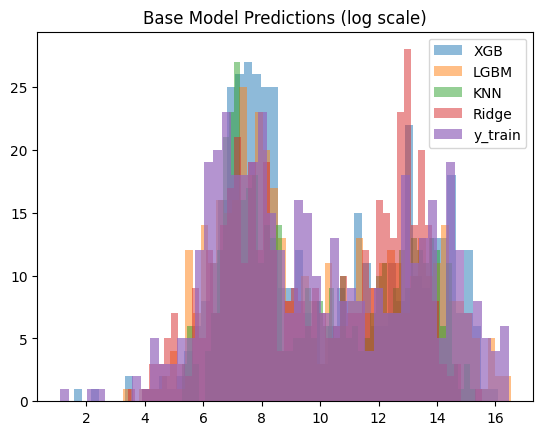

In [ ]:
import matplotlib.pyplot as plt
plt.hist(xgb_train, bins=50, alpha=0.5, label='XGB')
plt.hist(lgbm_train, bins=50, alpha=0.5, label='LGBM')
plt.hist(knn_train, bins=50, alpha=0.5, label='KNN')
plt.hist(ridge_train, bins=50, alpha=0.5, label='Ridge')
plt.hist(y_train_n, bins=50, alpha=0.7, label='y_train')
plt.legend()
plt.title("Base Model Predictions (log scale)")
plt.show()


In [ ]:
# Meta model

Stack_final_X_train = np.concatenate((lgbm_train, xgb_train, GB_train), axis=1)
Stack_final_X_val = np.concatenate((lgbm_test, xgb_test, GB_test), axis=1)

scaler = StandardScaler()
Stack_final_X_train_scaled = scaler.fit_transform(Stack_final_X_train)
Stack_final_X_val_scaled = scaler.transform(Stack_final_X_val)

meta_model_reg = Ridge(alpha=1.0)
meta_model_reg.fit(Stack_final_X_train_scaled, y_train)
y_val_log_pred = meta_model_reg.predict(Stack_final_X_val_scaled)

mse = mean_squared_error(y_val, np.expm1(y_val_log_pred))
rmse = np.sqrt(mse)
print(rmse)

9.947215308054234


In [ ]:
xgb_test = xgb_reg.predict(X_test_scaled).reshape(-1, 1)
lgbm_test = lgbm_reg.predict(X_test_scaled).reshape(-1, 1)
gb_test  = gb_reg.predict(X_test_scaled).reshape(-1, 1)

Stack_final_X_test = np.concatenate([xgb_test, lgbm_test, gb_test], axis=1)

Stack_final_X_test_scaled = scaler.transform(Stack_final_X_test)
y_test_log_pred_stacking = meta_model_reg.predict(Stack_final_X_test_scaled)


# 4. 제출 파일 생성

In [ ]:
# 역변환
y_test_pred = np.expm1(y_test_log_pred_stacking)

# 제출 파일 생성
submission['box_off_num'] = y_test_pred
submission['box_off_num'] = (
    submission['box_off_num']
    .fillna(0)                        # NaN 제거
    .clip(lower=0)                    # 음수 제거
    .astype(int)              # 정수 변환
)


submission.to_csv('submission.csv', index=False)


In [ ]:
submission.head()

,title,box_off_num
0,용서는 없다,573243
1,아빠가 여자를 좋아해,1368827
2,하모니,626542
3,의형제,2290090
4,평행 이론,513352
